In [1]:
# Function to extract the block index from the block ID string
def extract_block_index(block_id):
    return int(block_id.split('_')[-1])

# Test the function
sample_block_ids = ["1_2_12", "1_2_123", "1_2_1234"]
block_indexes = [extract_block_index(id) for id in sample_block_ids]
block_indexes

[12, 123, 1234]

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def extract_block_index(block_id):
    return int(block_id.split('_')[-1])
    
def create_latency_plots(df, window_size=20, marker_size=50, GTnumber=-1):
    sns.set(font_scale=1.5)

    # Calculate the rolling average for each unique path (combination of Source and Destination)
    df['Path'] = df['Source'].astype(str) + ' -> ' + df['Destination'].astype(str)
    df['Latency_Rolling_Avg'] = df.groupby('Path')['Latency'].transform(lambda x: x.rolling(window=window_size).mean())
    
    # Metrics for x-axis
    # metrics = ['Arrival Time', 'Block Index', 'Creation Time']
    metrics = ['Arrival Time', 'Creation Time']

    # Create subplots
    fig, axes = plt.subplots(len(metrics), 2, figsize=(18, 18))
    
    for i, metric in enumerate(metrics):
        # Line Plots on the left (column index 0)
        sns.lineplot(x=metric, y='Latency_Rolling_Avg', hue='Path', ax=axes[i, 0], data=df, legend=False)
        axes[i, 0].set_title(f'Latency Trends Over {metric} (Window Size = {window_size})')
        axes[i, 0].set_xlabel(metric)
        axes[i, 0].set_ylabel('Latency (Rolling Average)')
        
        # Scatter Plots on the right (column index 1)
        sns.scatterplot(x=metric, y='Latency', hue='Path', ax=axes[i, 1], data=df, marker='o', s=marker_size, legend=False)
        axes[i, 1].set_title(f'Individual Latency Points Over {metric}')
        axes[i, 1].set_xlabel(metric)
        axes[i, 1].set_ylabel('Latency')
        
    # Adjust the layout
    plt.tight_layout()
    # plt.savefig(outputPath + '/pngAllLatencies/' + '{}_gateways_All_Latencies_subplots.png'.format(GTnumber), dpi = 300)
    plt.savefig(source + '.png', dpi = 300)
    plt.show()
    plt.close()
    sns.set(font_scale=1.0)


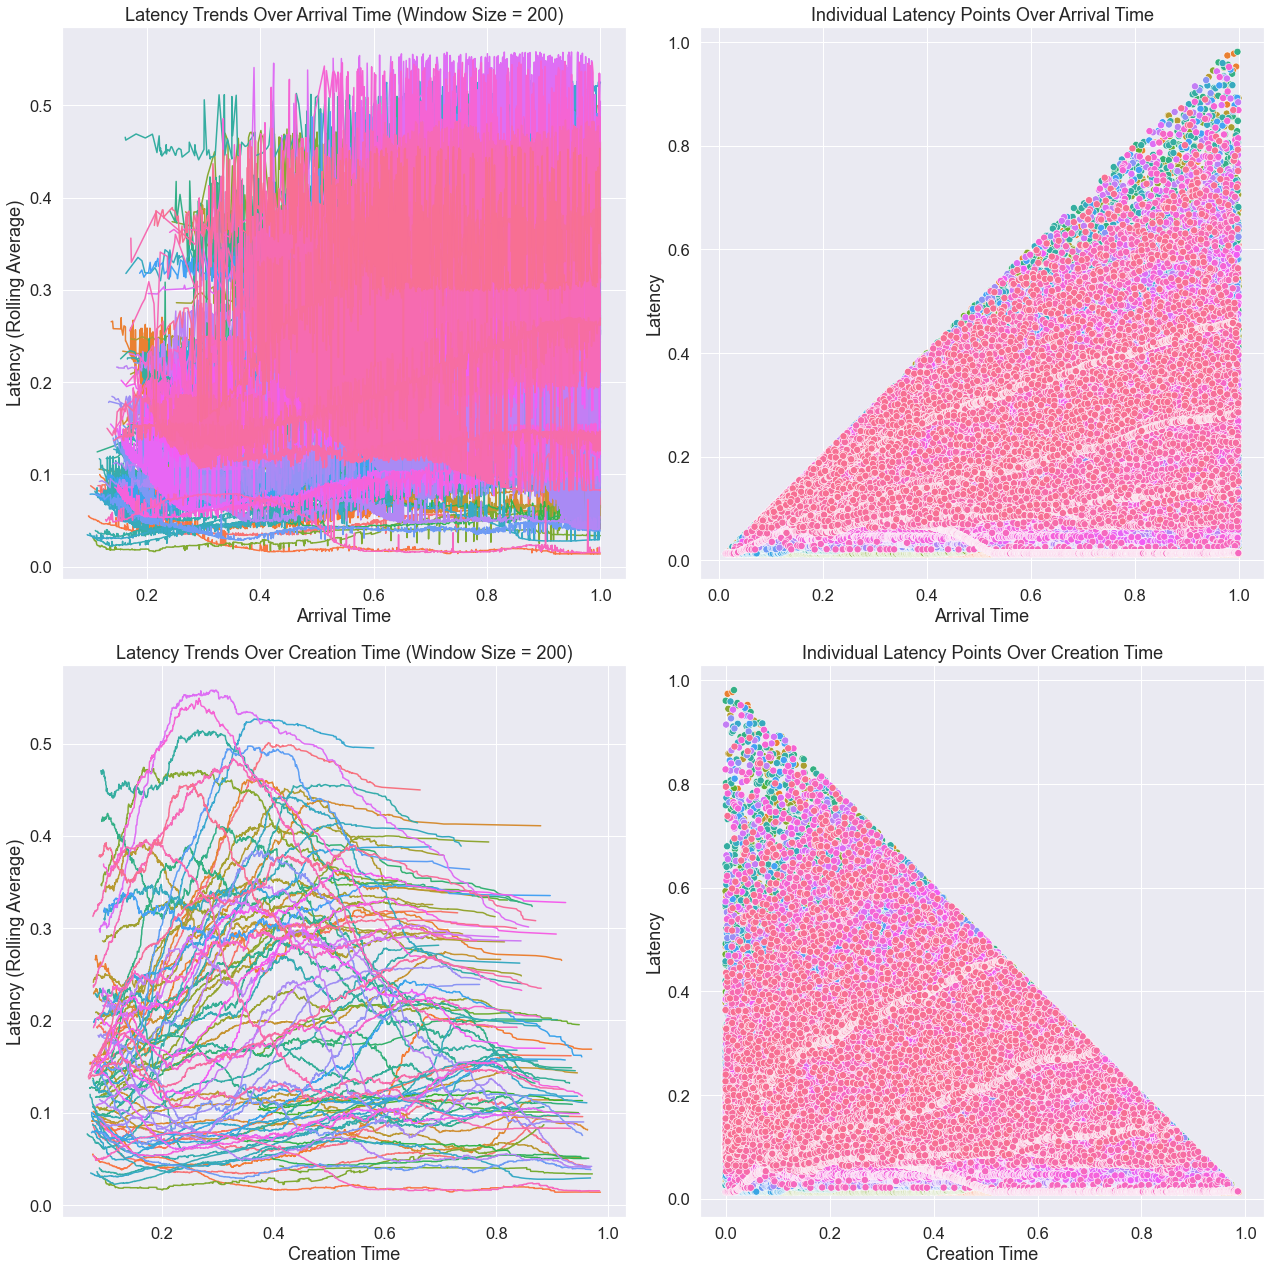

,Unnamed: 0,Creation Time,Latency,Arrival Time,Source,Destination,Block ID,Block Index
0,2119,0.000000,0.091619,0.091619,"Aalborg, Denmark","Bangalore, India (partner station)",2_8_0,0
1,884,0.000915,0.070127,0.071042,"Aalborg, Denmark","Bangalore, India (partner station)",2_8_1,1
2,4879,0.001124,0.122403,0.123527,"Aalborg, Denmark","Bangalore, India (partner station)",2_8_2,2
3,9103,0.001172,0.155806,0.156978,"Aalborg, Denmark","Bangalore, India (partner station)",2_8_3,3
4,13598,0.001948,0.186494,0.188442,"Aalborg, Denmark","Bangalore, India (partner station)",2_8_4,4
...,...,...,...,...,...,...,...,...
134987,125006,0.766766,0.165104,0.931870,"Tolhuin, Argentina (partner station)","Tokyo, Japan",4_9_2108,2108
134988,115624,0.768756,0.098701,0.867457,"Tolhuin, Argentina (partner station)","Tokyo, Japan",4_9_2111,2111
134989,113152,0.770038,0.078677,0.848715,"Tolhuin, Argentina (partner station)","Tokyo, Japan",4_9_2115,2115
134990,122493,0.814989,0.100399,0.915389,"Tolhuin, Argentina (partner station)","Tokyo, Japan",4_9_2233,2233


In [4]:
# Read the newly uploaded CSV file into a raw DataFrame
source = './allLatencies_10_gateways'
df_raw = pd.read_csv(source + '.csv')

# remove aalborg
# df_raw = df_raw[(df_raw['Source'] != 'Aalborg, Denmark') & (df_raw['Destination'] != 'Aalborg, Denmark')]

# Extract the data block index from the Block ID in the raw DataFrame
df_raw['Block Index'] = df_raw['Block ID'].apply(extract_block_index)

# Sort the DataFrame by paths (Source and Destination)
df_sorted_by_paths_raw = df_raw.sort_values(by=['Source', 'Destination', 'Block Index'])

# Test the updated function on the raw DataFrame with a window size of 20
create_latency_plots(df_sorted_by_paths_raw, window_size=200)

df_raw


In [7]:
!dir

 El volumen de la unidad T es DATOS
 El n�mero de serie del volumen es: 6648-9550

 Directorio de t:\Fede\SatNEx_code\tests

17/10/2023  10:17    <DIR>          .
17/10/2023  10:17    <DIR>          ..
09/10/2023  17:39             5.684 allLatencies_2gateways.csv
13/10/2023  03:59         1.806.350 allLatencies_3_gateways.csv
17/10/2023  10:19            15.309 becaria.ipynb
10/10/2023  14:41               124 logfile.log
               4 archivos      1.827.467 bytes
               2 dirs  168.024.330.240 bytes libres
